# Predicting Airbnb Listing Prices with MLflow and AWS S3

## Context
You are part of the Data Science team at StayWise, a global vacation rental platform. The company aims to enhance its pricing system to help hosts set competitive rates. Currently, all listing and booking data are stored in AWS S3, and the data science workflow uses MLflow for experiment tracking and model management.

## Problem Statement
Listing prices on StayWise vary significantly, even among similar properties. The business team wants a machine learning model that predicts the optimal nightly price for new listings based on factors such as location, amenities, and reviews. The dataset from S3 is noisy, containing missing values, outliers, and categorical fields that require extensive preprocessing. Your task is to build a clean, reproducible modelling pipeline using MLflow to track experiments and evaluate models.

## Objective
As a Data Scientist at StayWise, you are expected to:

1. Retrieve the Airbnb listings dataset from AWS S3 for analysis.

2. Perform end-to-end data preprocessing, including cleaning, feature engineering, and outlier handling.

3. Develop and compare multiple regression models to predict nightly listing prices.

4. Track all experiments using MLflow and register the best model.

5. Present your results clearly through a well-documented GitHub repository.

## Steps and Requirements

### 1. Dataset Storage (AWS S3)

The raw Airbnb dataset used in this project is `AB_NYC_2019.csv`, which contains New York City Airbnb listings for 2019. Instead of reading the data from a local file, the dataset is stored in an AWS S3 bucket to align with StayWise's cloud-based data infrastructure.

- **S3 bucket name:** `val-ai-ml-project-2077`
- **Object path:** `airbnb/raw_data/AB_NYC_2019.csv`
- **Full S3 URI:** `s3://vval-ai-ml-project-2077/airbnb/raw_data/listings.csv`

Successfully load the dataset directly from S3 and perform basic sanity checks to confirm that the storage and access setup is working properly.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
import warnings

# Hide warnings only from s3fs or boto3
warnings.filterwarnings("ignore", module="s3fs")
warnings.filterwarnings("ignore", module="boto3")

import pandas as pd

s3_path = "s3://val-ai-ml-project-2077/airbnb/raw_data/AB_NYC_2019.csv"

df = pd.read_csv(s3_path)

df.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


### 2. Data Cleaning and Preprocessing  

**Observations:**

- The dataset contains **48,895 records and 16 features**.
- Most fields match their expected types based on the data dictionary.
- The `last_review` column is stored as **object (string)** instead of a date → needs conversion to datetime.
- `last_review` and `reviews_per_month` both contain **10,052 missing values**, corresponding to listings with no reviews.
- Columns such as `id`, `name`, `host_id`, and `host_name` are identifiers or text fields that are **not useful for prediction** → will be dropped.
- The `neighbourhood` column has **221 unique categories**, too high for one-hot encoding → will be dropped.
- `price` and `minimum_nights` contain **extreme outliers** that must be removed or capped.
- Categorical variables (`neighbourhood_group`, `room_type`) are stored as **object** and will require encoding.


In [3]:
df.shape

(48895, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [5]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [6]:
df['neighbourhood'].nunique()

221

In [7]:
df['neighbourhood_group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [8]:
df['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [9]:
# Dropping unnecessary columns
cols_to_drop = ['id', 'name', 'host_id', 'host_name', 'neighbourhood']

df = df.drop(columns=cols_to_drop)

print(df.shape)
print(df.columns)

(48895, 11)
Index(['neighbourhood_group', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')


In [10]:
# Convert last_review to datetime data type
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

print(df['last_review'].dtype)
print(df['last_review'].isnull().sum())

datetime64[ns]
10052


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   neighbourhood_group             48895 non-null  object        
 1   latitude                        48895 non-null  float64       
 2   longitude                       48895 non-null  float64       
 3   room_type                       48895 non-null  object        
 4   price                           48895 non-null  int64         
 5   minimum_nights                  48895 non-null  int64         
 6   number_of_reviews               48895 non-null  int64         
 7   last_review                     38843 non-null  datetime64[ns]
 8   reviews_per_month               38843 non-null  float64       
 9   calculated_host_listings_count  48895 non-null  int64         
 10  availability_365                48895 non-null  int64         
dtypes:

**Observations**

- Missing values in `last_review` and `reviews_per_month` both occur in exactly 10,052 rows. 
- These rows correspond to listings where `number_of_reviews` is 0. 
- Since a listing with no reviews cannot have a last review date or review frequency,  these missing values represent “no reviews” rather than random data loss.

In [12]:
df[df['number_of_reviews'] == 0][['last_review', 'reviews_per_month']].head()


,last_review,reviews_per_month
2,NaT,NaN
19,NaT,NaN
26,NaT,NaN
36,NaT,NaN
38,NaT,NaN


In [13]:
df[df['number_of_reviews'] == 0].shape[0]


10052

#### Handling the missing values:
- Create a binary feature `has_review` indicating whether the listing has at least one review.
- Impute missing `reviews_per_month` values with 0, since listings without reviews receive 0 reviews per month.
- Keep `last_review` as `NaT` for listings with no reviews; it will be used later to derive recency-based features if needed.

In [14]:
# Create binary feature
df['has_review'] = df['last_review'].notna().astype(int)

# Impute the value 0 for missing data
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [15]:
df[['last_review', 'has_review', 'reviews_per_month']].head()

,last_review,has_review,reviews_per_month
0,2018-10-19,1,0.21
1,2019-05-21,1,0.38
2,NaT,0,0.00
3,2019-07-05,1,4.64
4,2018-11-19,1,0.10


In [16]:
df[['last_review', 'reviews_per_month']].isna().sum()

last_review          10052
reviews_per_month        0
dtype: int64

In [17]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
latitude,48895.0,40.728949,40.49979,40.6901,40.72307,40.763115,40.91306,0.05453
longitude,48895.0,-73.95217,-74.24442,-73.98307,-73.95568,-73.936275,-73.71299,0.046157
price,48895.0,152.720687,0.0,69.0,106.0,175.0,10000.0,240.15417
minimum_nights,48895.0,7.029962,1.0,1.0,3.0,5.0,1250.0,20.51055
number_of_reviews,48895.0,23.274466,0.0,1.0,5.0,24.0,629.0,44.550582
last_review,38843,2018-10-04 01:47:23.910099456,2011-03-28 00:00:00,2018-07-08 00:00:00,2019-05-19 00:00:00,2019-06-23 00:00:00,2019-07-08 00:00:00,NaN
reviews_per_month,48895.0,1.09091,0.0,0.04,0.37,1.58,58.5,1.597283
calculated_host_listings_count,48895.0,7.143982,1.0,1.0,1.0,2.0,327.0,32.952519
availability_365,48895.0,112.781327,0.0,0.0,45.0,227.0,365.0,131.622289
has_review,48895.0,0.794417,0.0,1.0,1.0,1.0,1.0,0.404131


#### Outlier Handling

**Observation:**
Several numerical columns show extreme values, but not all of them should be treated as outliers.

**Price (target variable)**
- The `price` column contains unusually high values (some > $1,000).
- Although such prices may exist in real life, they represent less than 1% of listings and heavily distort regression models.
- Because `price` is the target variable, extreme values can disproportionately influence model training and inflate errors.
- **Action:** Remove listings with very high prices (e.g., > $1,000).


**Minimum Nights**
- `minimum_nights` contains unrealistic values (e.g., 365 or even 1000).
- Airbnb stays typically range from 1–30 nights; extremely high values reflect long-term rental policies rather than typical nightly stays.
- These extreme values behave differently from normal listings and add noise to the model.
- **Action:** Cap `minimum_nights` at 30 nights.


#### Retaining “Outlier-looking” Values (Legitimate Skew)

**Number of Reviews**
- Naturally right-skewed: a few listings have hundreds of reviews.
- These are **not errors** but meaningful indicators of listing popularity.
- Removing them would remove important predictive information.
- **Action:** Retain all values.

**Reviews per Month**
- Higher values indicate high-performing or seasonal listings.
- The distribution is skewed but still realistic.
- **Action:** Retain all values.

**Calculated Host Listings Count**
- Large host counts (e.g., 50–200) reflect professional hosts or property managers.
- These values carry important signal for pricing patterns.
- **Action:** Retain all values.


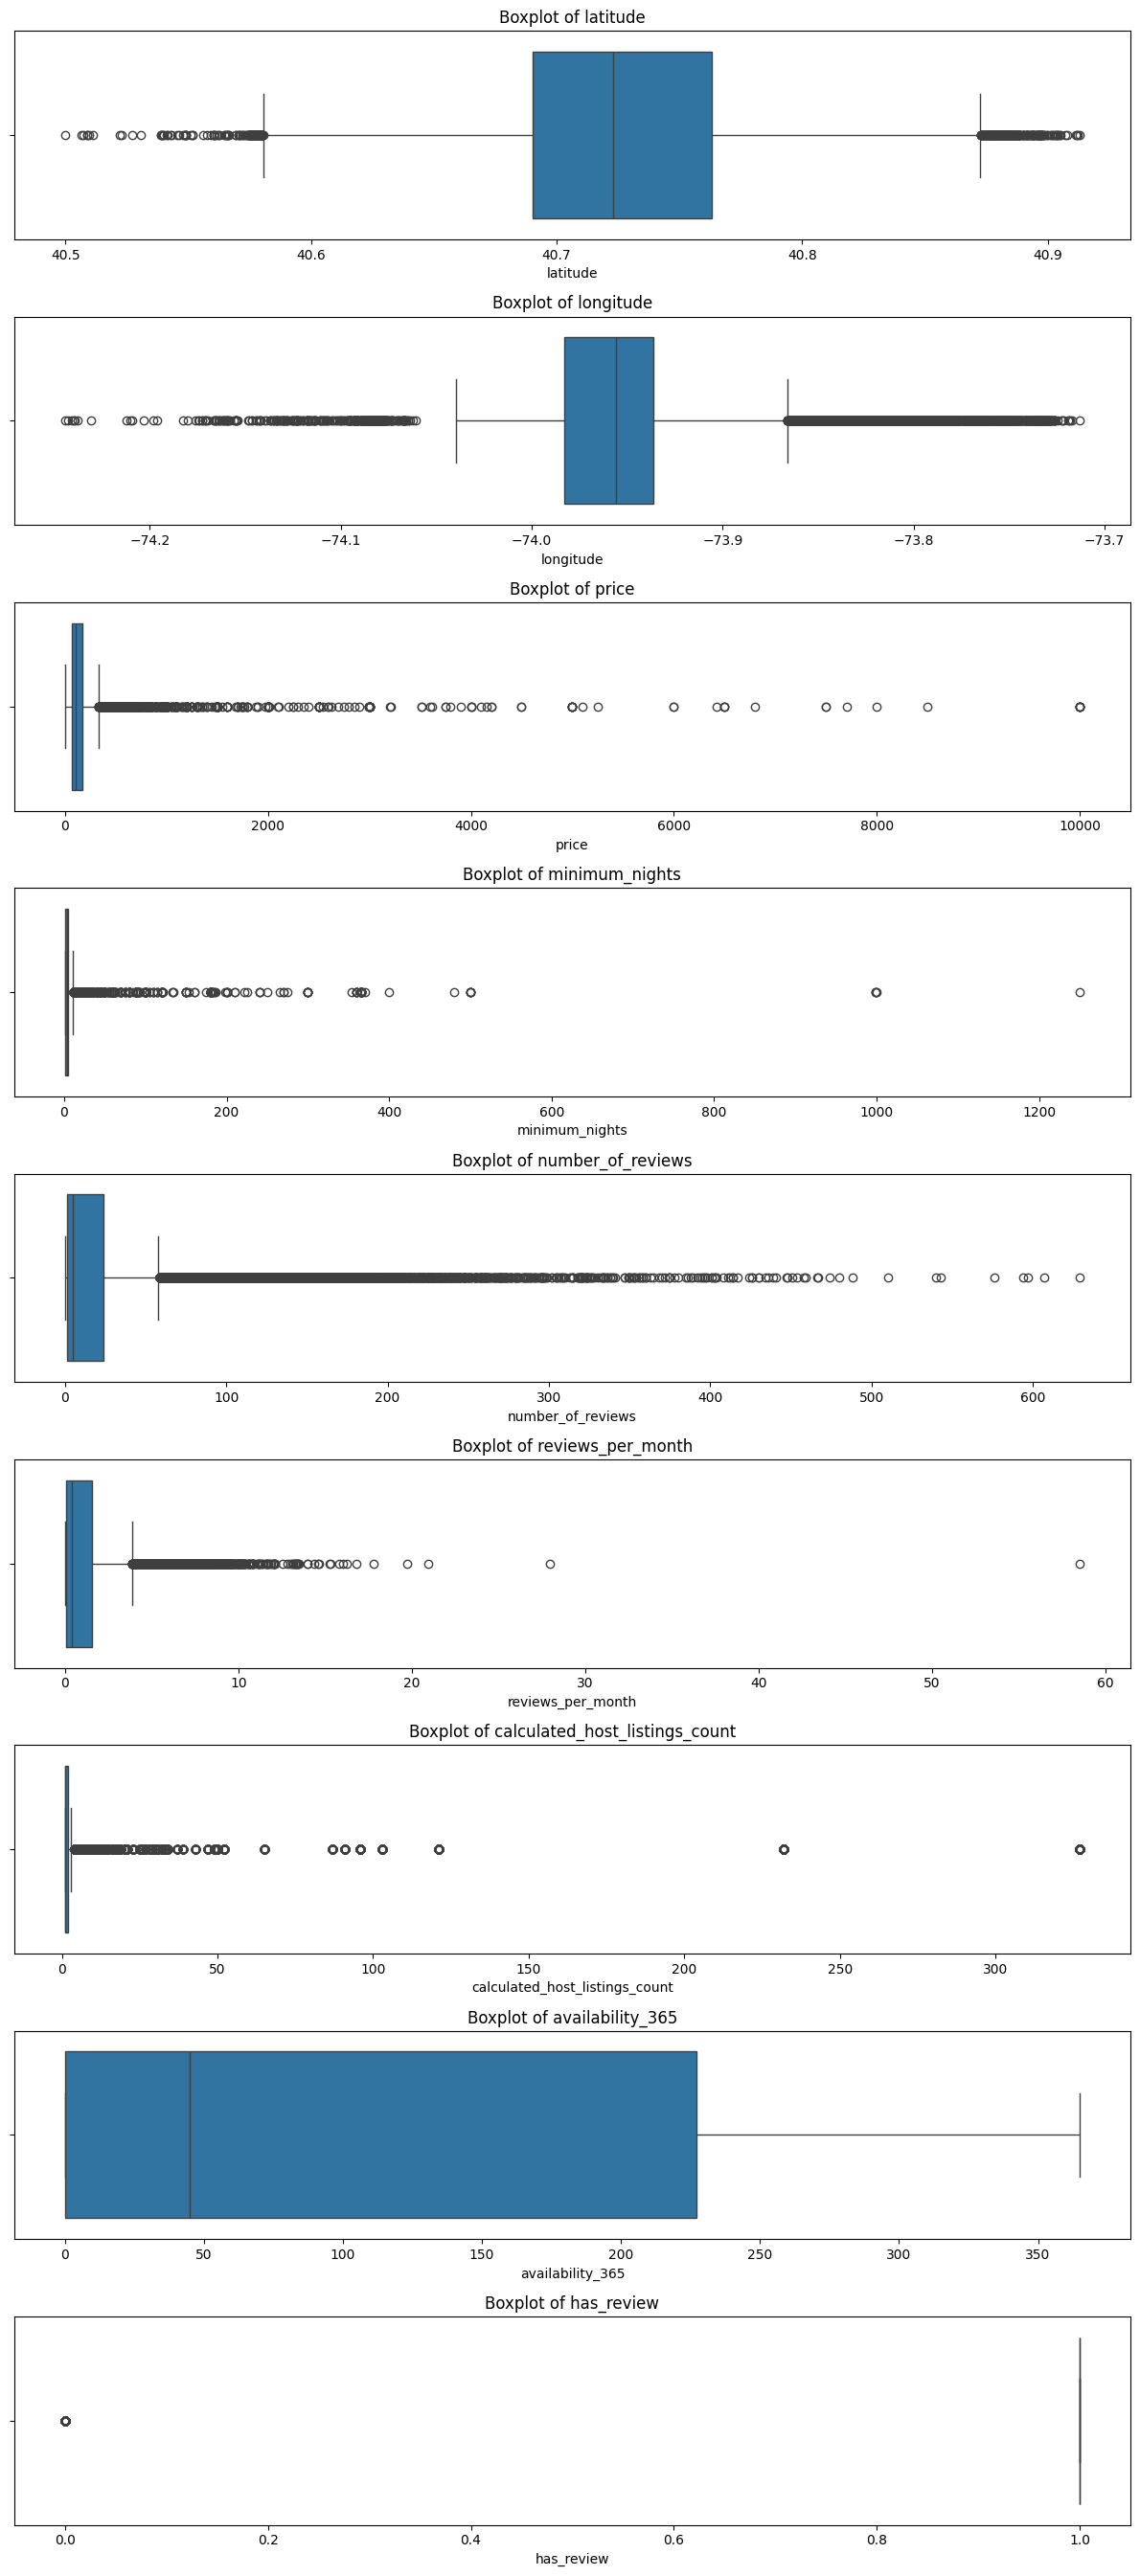

In [ ]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Boxplots for numeric columns
plt.figure(figsize=(12, 3 * len(numeric_cols)))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=df[col], orient='h')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    
plt.tight_layout()
plt.show()


In [ ]:
# Remove extreme price values
df = df[df['price'].between(10, 1000)]

# Cap unrealistic minimum_nights values
df['minimum_nights'] = df['minimum_nights'].clip(upper=30)

In [ ]:
# Sanity checks
print("Price range after cleaning:", df['price'].min(), "to", df['price'].max())
print("Minimum nights after capping:", df['minimum_nights'].min(), "to", df['minimum_nights'].max())
print("New dataset shape:", df.shape)


Price range after cleaning: 10 to 1000
Minimum nights after capping: 1 to 30
New dataset shape: (48645, 12)


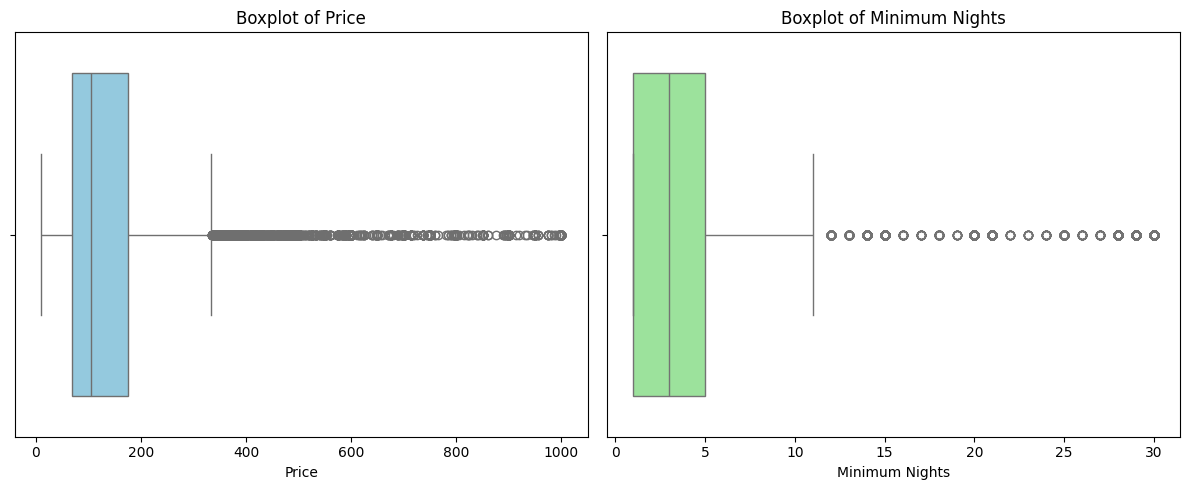

In [ ]:
# Boxplots after cleaning
plt.figure(figsize=(12, 5))

# Boxplot for price
plt.subplot(1, 2, 1)
sns.boxplot(x=df['price'], color="skyblue")
plt.title("Boxplot of Price")
plt.xlabel("Price")

# Boxplot for minimum_nights
plt.subplot(1, 2, 2)
sns.boxplot(x=df['minimum_nights'], color="lightgreen")
plt.title("Boxplot of Minimum Nights")
plt.xlabel("Minimum Nights")

plt.tight_layout()
plt.show()


#### Encoding Categorical Variables

**Observations:**
- `neighbourhood_group` and `room_type` are stored as `object` type and represent categorical features.
- Both columns have a small number of distinct categories, making them suitable for one-hot encoding.
- One dummy column is dropped (`drop_first=True`) to avoid **multicollinearity**, a problem where dummy variables are perfectly correlated with each other.
- This approach improves model interpretability and prevents numerical issues while still retaining all categorical information.

In [22]:
df['neighbourhood_group'].value_counts()

neighbourhood_group
Manhattan        21488
Brooklyn         20041
Queens            5656
Bronx             1089
Staten Island      371
Name: count, dtype: int64

In [23]:
df['room_type'].value_counts()

room_type
Entire home/apt    25216
Private room       22273
Shared room         1156
Name: count, dtype: int64

In [24]:
# One-hot encoding
categorical_cols = ['neighbourhood_group', 'room_type']

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [25]:
df_encoded.shape

(48645, 16)

In [26]:
df_encoded.columns

Index(['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'has_review', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'room_type_Private room',
       'room_type_Shared room'],
      dtype='object')

In [27]:
df['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [28]:
df.columns

Index(['neighbourhood_group', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'has_review'],
      dtype='object')

#### Feature Engineering: Days Since Last Review

**Observations:**
- The `last_review` column is now stored as a datetime type, but machine learning models cannot work directly with date objects.
- Datetime values need to be converted into a numerical format for modeling.
- Listings with no reviews contain `NaT` values in the `last_review` column.

In [29]:
# Get the most recent review date and use it as reference point
max_date = df['last_review'].max()

# Create the days_since_last_review feature
df['days_since_last_review'] = (max_date - df['last_review']).dt.days

# For listings with no reviews (NaT), replace with max days
df['days_since_last_review'] = df['days_since_last_review'].fillna(df['days_since_last_review'].max())

# Drop the original datetime column
df = df.drop(columns=['last_review'])

# Check results
df[['has_review', 'days_since_last_review']].head()


,has_review,days_since_last_review
0,1,262.0
1,1,48.0
2,0,3024.0
3,1,3.0
4,1,231.0


#### EDA

**Observations**
1. Correlation Heatmap
- Number of reviews and reviews per month show strong positive correlation, indicating active listings tend to accumulate reviews consistently over time.
- Price shows weak to moderate negative correlation with longitude and private room type, suggesting pricing patterns vary by location and accommodation type.
- Room type variables show expected negative correlations with each other, as they are mutually exclusive categories.
- Most variables show weak correlations with price, indicating that pricing is influenced by multiple factors rather than any single feature.

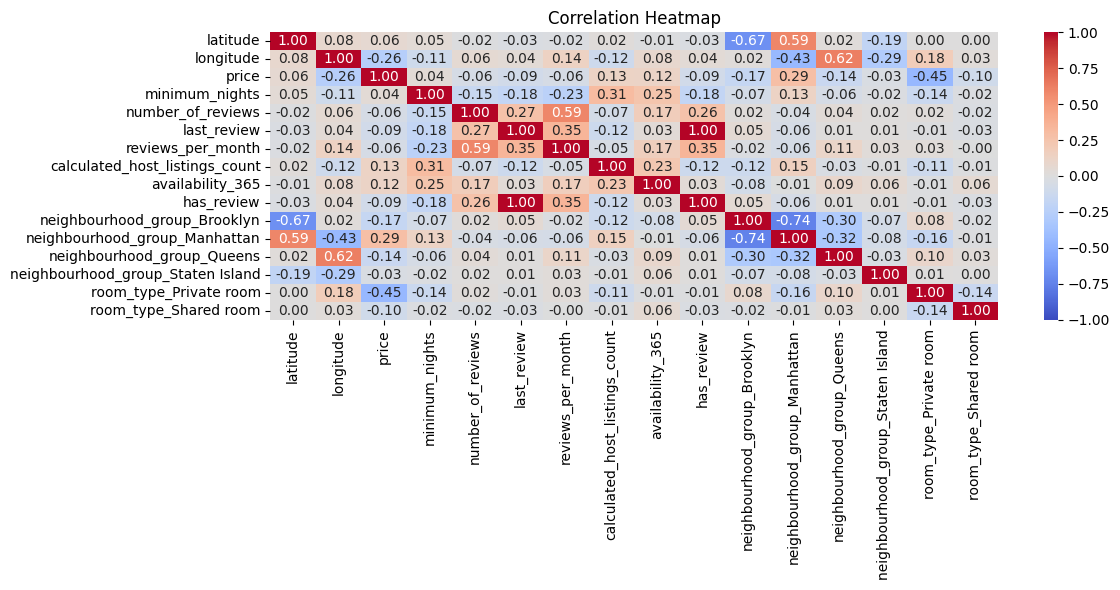

In [30]:
# Correlation Heatmap
corr = df_encoded.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(
    corr,
    annot=True,    
    fmt=".2f",     
    cmap="coolwarm",
    vmin=-1,
    vmax=1
)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


**Observations**

2. Price Distribution
- The distribution of `price` is right-skewed, with most listings priced between \$50 and \$200.
- Prices decrease sharply after around \$300, and very high prices become rare.
- The long tail confirms that a small number of high-price listings remain even after capping extreme values.


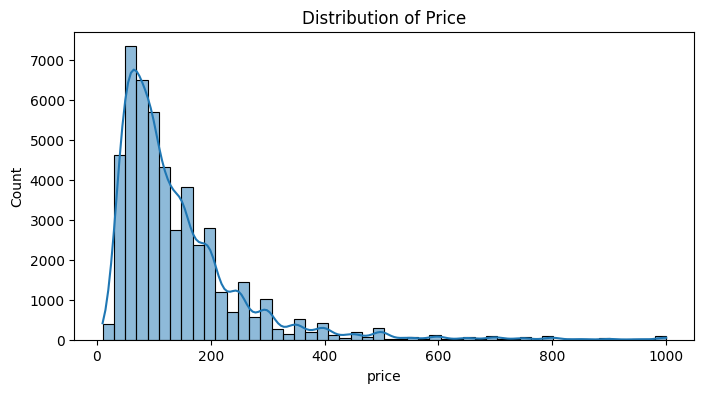

In [ ]:
# Histogram of price
plt.figure(figsize=(8,4))
sns.histplot(df_encoded['price'], bins=50, kde=True)
plt.title("Distribution of Price")
plt.show()


**Observations**

3. Price by Room Type
- Entire homes/apartments command the highest prices, followed by private rooms, with shared rooms having the lowest median price.
- The pricing hierarchy aligns with expected value where exclusive space costs more than shared accommodations.
- All room types exhibit significant outliers extending to $1000, with entire homes/apartments showing the widest interquartile range, indicating substantial pricing diversity within each category.

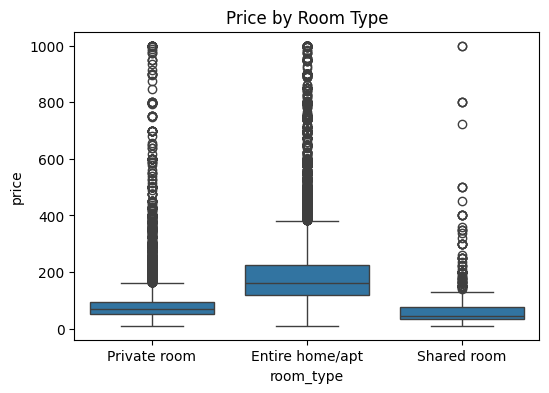

In [ ]:
# Boxplot of price by room type
plt.figure(figsize=(6,4))
sns.boxplot(x=df['room_type'], y=df['price'])
plt.title("Price by Room Type")
plt.show()


**Observations** 

4. Price by Neighbourhood Group
- Manhattan shows the highest overall price levels compared to other boroughs.
- Brooklyn has moderately high prices, while Queens, Staten Island, and the Bronx tend to have lower median prices.
- All neighbourhood groups contain high-price outliers, but the concentration of higher prices is visibly strongest in Manhattan.


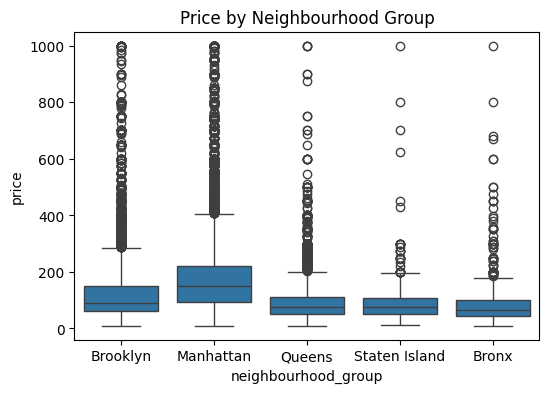

In [ ]:
# Boxplot of price by neighbourhood group
plt.figure(figsize=(6,4))
sns.boxplot(x=df['neighbourhood_group'], y=df['price'])
plt.title("Price by Neighbourhood Group")
plt.show()


### 3. Model Development

#### 3.1 Preparing Features and Target
- Use the cleaned dataframe as input for modeling.
- Define `price` as the target variable.
- Apply one-hot encoding again to `neighbourhood_group` and `room_type` so that all features are numeric, including the engineered `days_since_last_review`.


In [34]:
# Recreate encoded dataframe from the latest cleaned df
categorical_cols = ['neighbourhood_group', 'room_type']

df_model = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separate features and target
X = df_model.drop(columns=['price'])
y = df_model['price']

X.shape, y.shape, X.columns


((48645, 15),
 (48645,),
 Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
        'reviews_per_month', 'calculated_host_listings_count',
        'availability_365', 'has_review', 'days_since_last_review',
        'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan',
        'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island',
        'room_type_Private room', 'room_type_Shared room'],
       dtype='object'))

#### 3.2 Train/Test Split and Baseline Model

- Split the data into 80% training and 20% testing using a fixed random_state for reproducibility.
- Train a simple baseline model (`DummyRegressor`) that always predicts the mean price.
- This baseline provides a reference point to evaluate whether more complex models actually improve performance.

##### Baseline Model Results
**Observations:**
- **MAE:** 79.01  
- **RMSE:** 118.12  
- **R²:** -0.000004

- The baseline model predicts the same price (the average) for every listing, so its errors (MAE and RMSE) show how far off this simple prediction is from the real prices.
- The R² value is essentially 0, meaning the model does not explain any variation in listing prices.
- These results form a reference point; any meaningful regression model should perform better than this baseline by reducing the errors and achieving a positive R².

In [35]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Baseline model: predicts mean price
baseline_model = DummyRegressor(strategy='mean')
baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_test)

baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
baseline_r2 = r2_score(y_test, y_pred_baseline)

baseline_mae, baseline_rmse, baseline_r2

(79.01390305239933, np.float64(118.12101047462495), -4.364204136964034e-06)

##### Linear Regression Results

**Observations:**
- **MAE:** 57.19  
- **RMSE:** 96.20  
- **R²:** 0.337

- Compared to the baseline model (MAE ≈ 79, RMSE ≈ 118, R² ≈ 0), Linear Regression shows a clear improvement.
- The reduction in MAE and RMSE means the model’s predictions are noticeably closer to the actual prices.
- The R² value of **0.337** indicates that Linear Regression explains about **33.7%** of the variation in listing prices which is a meaningful improvement from the baseline, but still leaves a large amount unexplained.
- This suggests that while the linear model captures some useful patterns, the relationship between features and price is likely **non-linear**, meaning more flexible models may perform better.


In [36]:
# Train Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions
y_pred_lin = lin_reg.predict(X_test)

# Metrics
lin_mae = mean_absolute_error(y_test, y_pred_lin)
lin_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lin))
lin_r2 = r2_score(y_test, y_pred_lin)

lin_mae, lin_rmse, lin_r2

(57.188293347985656, np.float64(96.19802487618871), 0.3367459679264849)

##### Random Forest Results

**Observations:**
- **MAE:** 49.53  
- **RMSE:** 87.08  
- **R²:** 0.457  


- Random Forest outperforms both the baseline model and Linear Regression across all metrics.
- The MAE dropped from ~57 (Linear Regression) to ~49, meaning the model is making smaller average errors.
- The RMSE also improved noticeably, indicating better handling of larger errors.
- The R² value increased to **0.457**, meaning Random Forest explains about **45.7%** of the variation in listing prices—significantly higher than Linear Regression (33.7%).
- These results suggest that Airbnb prices have **non-linear patterns** and interactions that a tree-based model can capture more effectively than a linear model.
- Random Forest is currently the **best-performing model**, and is a strong candidate for MLflow experiment tracking and model registration.


In [ ]:
# Train Random Forest model
rf_reg = RandomForestRegressor(
    n_estimators=200,     
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_reg.predict(X_test)

# Metrics
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

rf_mae, rf_rmse, rf_r2


(49.53115822112584, np.float64(87.08132138996292), 0.45650242670897223)

### 4. Experiment Tracking with MLflow

MLflow was used to log and compare all model training runs, including the baseline, Linear Regression, and Random Forest models.

**Observations:**
- Each run captured key parameters (e.g., model type, hyperparameters) and evaluation metrics (MAE, RMSE, R²).
- The baseline model showed the highest errors and no explanatory power, serving as a reference point.
- Linear Regression improved performance significantly, showing that the features have predictive value.
- Random Forest achieved the best results across all metrics, confirming it as the strongest model for this dataset.
- The final Random Forest model was registered in the MLflow Model Registry under the name `AirbnbPriceModel` for future reuse and versioning.


In [ ]:
# Change working directory to project root
#import os
#os.chdir("..")
#os.getcwd()

In [46]:
import mlflow
import mlflow.sklearn

In [ ]:
# MLflow setup
#mlflow.set_experiment("airbnb_price_prediction")

In [48]:
import logging
logging.getLogger("mlflow").setLevel(logging.ERROR)

In [51]:
# Baseline model with MLflow logging
with mlflow.start_run(run_name="Baseline_v1"):
    # 1. Define and train baseline model (predicts mean price)
    baseline_model = DummyRegressor(strategy="mean")
    baseline_model.fit(X_train, y_train)

    # 2. Predict on test set
    y_pred_base = baseline_model.predict(X_test)

    # 3. Compute metrics
    base_mae = mean_absolute_error(y_test, y_pred_base)
    base_rmse = np.sqrt(mean_squared_error(y_test, y_pred_base))
    base_r2 = r2_score(y_test, y_pred_base)

    # 4. Log parameters
    mlflow.log_param("model_type", "DummyRegressor")
    mlflow.log_param("strategy", "mean")

    # 5. Log metrics
    mlflow.log_metric("MAE", base_mae)
    mlflow.log_metric("RMSE", base_rmse)
    mlflow.log_metric("R2", base_r2)

base_mae, base_rmse, base_r2


(79.01390305239933, np.float64(118.12101047462495), -4.364204136964034e-06)

In [49]:
# Log Linear Regression model to MLflow
with mlflow.start_run(run_name="LinearRegression_v1"):
    # 1. Train model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    # 2. Predictions
    y_pred_lin = lin_reg.predict(X_test)

    # 3. Metrics
    lin_mae = mean_absolute_error(y_test, y_pred_lin)
    lin_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lin))
    lin_r2 = r2_score(y_test, y_pred_lin)

    # 4. Log parameters
    mlflow.log_param("model_type", "LinearRegression")

    # 5. Log metrics
    mlflow.log_metric("MAE", lin_mae)
    mlflow.log_metric("RMSE", lin_rmse)
    mlflow.log_metric("R2", lin_r2)

    # 6. Log model artifact
    mlflow.sklearn.log_model(lin_reg, artifact_path="model")

lin_mae, lin_rmse, lin_r2

(57.188293347985656, np.float64(96.19802487618871), 0.3367459679264849)

In [ ]:
# Log Random Forest model to MLflow
with mlflow.start_run(run_name="RandomForest_v1"):
    rf_reg = RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )

    rf_reg.fit(X_train, y_train)
    y_pred_rf = rf_reg.predict(X_test)

    rf_mae = mean_absolute_error(y_test, y_pred_rf)
    rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    rf_r2 = r2_score(y_test, y_pred_rf)

    # Log parameters (hyperparameters)
    mlflow.log_param("model_type", "RandomForestRegressor")
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("max_depth", rf_reg.max_depth)
    mlflow.log_param("random_state", 42)

    # Log metrics
    mlflow.log_metric("MAE", rf_mae)
    mlflow.log_metric("RMSE", rf_rmse)
    mlflow.log_metric("R2", rf_r2)

    # Log model
    mlflow.sklearn.log_model(rf_reg, artifact_path="model")

rf_mae, rf_rmse, rf_r2

(49.53115822112584, np.float64(87.08132138996292), 0.45650242670897223)

In [52]:
# Final Random Forest model with MLflow logging and model registry
with mlflow.start_run(run_name="RandomForest_final"):
    # 1. Define and train Random Forest
    rf_final = RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    rf_final.fit(X_train, y_train)

    # 2. Predict on test set
    y_pred_rf_final = rf_final.predict(X_test)

    # 3. Compute metrics
    rf_final_mae = mean_absolute_error(y_test, y_pred_rf_final)
    rf_final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_final))
    rf_final_r2 = r2_score(y_test, y_pred_rf_final)

    # 4. Log parameters
    mlflow.log_param("model_type", "RandomForestRegressor")
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("random_state", 42)

    # 5. Log metrics
    mlflow.log_metric("MAE", rf_final_mae)
    mlflow.log_metric("RMSE", rf_final_rmse)
    mlflow.log_metric("R2", rf_final_r2)

    # 6. Log AND register this model in the MLflow Model Registry
    mlflow.sklearn.log_model(
        rf_final,
        artifact_path="model",
        registered_model_name="AirbnbPriceModel"
    )

rf_final_mae, rf_final_rmse, rf_final_r2


Successfully registered model 'AirbnbPriceModel'.
Created version '1' of model 'AirbnbPriceModel'.


(49.53115822112584, np.float64(87.08132138996292), 0.45650242670897223)